In [1]:
#Load libraries

import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import shap
import lime
import lime.lime_tabular
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
#print('done')

In [2]:
#Load income dataset

dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
row_names = ["Age", "Workclass", "Fnlwgt", "Education", "EducationNum", "MaritalStatus",
        "Occupation", "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss",
        "HoursPerWeek", "Country", "Income"]
us_adult_income = pd.read_csv(dataset, names=row_names,na_values=[' ?'])

In [3]:
#Basic preprocessing and one hot encoding

del us_adult_income['CapitalGain']
del us_adult_income['CapitalLoss']
del us_adult_income['Education']
del us_adult_income['Relationship']
del us_adult_income['Country']

#print(us_adult_income)

one_hot_encoding = pd.get_dummies(us_adult_income)
one_hot_encoding.fillna(one_hot_encoding.mean(),inplace=True)
one_hot_encoding["Income"] = one_hot_encoding['Income_ >50K']
del one_hot_encoding['Income_ <=50K']
del one_hot_encoding['Income_ >50K']

#Split X, Y and create train test dataset
X = one_hot_encoding.iloc[:,0:-1]
Y = one_hot_encoding.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

In [4]:
#Build the random forest classifier
rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)

yPredRf = rf.predict(X_test)
print(metrics.classification_report(Y_test, yPredRf))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      6214
           1       0.74      0.40      0.52      1927

    accuracy                           0.82      8141
   macro avg       0.79      0.68      0.71      8141
weighted avg       0.81      0.82      0.80      8141



Text(0, 0.5, 'Cross-validated accuracy')

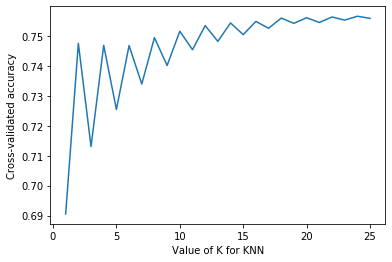

In [5]:
#Start KNN implementation. Do elbow method to define number of K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
# Number of k from 1 to 26
k_range = range(1, 26)
k_scores = []
# Calculate cross validation score for every k number from 1 to 26
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # It’s 10 fold cross validation with ‘accuracy’ scoring 
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())
    
%matplotlib inline
# Plot accuracy for every k number between 1 and 26
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [6]:
# Train the KNN model and use k=18 based on above graph

knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train, Y_train)
yPredKNN = knn.predict(X_test)

# classification report for test set
print(metrics.classification_report(Y_test, yPredKNN))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      6214
           1       0.35      0.02      0.04      1927

    accuracy                           0.76      8141
   macro avg       0.56      0.50      0.45      8141
weighted avg       0.67      0.76      0.67      8141



In [7]:
#Train the GNB model

gnb=GaussianNB()
gnb.fit(X_train,Y_train)

yPredGNB = gnb.predict(X_test)


# classification report for test set
print(metrics.classification_report(Y_test, yPredGNB))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      6214
           1       0.65      0.18      0.29      1927

    accuracy                           0.78      8141
   macro avg       0.72      0.58      0.58      8141
weighted avg       0.76      0.78      0.73      8141



In [8]:
#Train the XGB model

xgbModel = xgb.XGBClassifier(random_state=1)
xgbModel.fit(X_train, Y_train)
yPredXGB = xgbModel.predict(X_test)
print(metrics.classification_report(Y_test, yPredXGB))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6214
           1       0.69      0.59      0.63      1927

    accuracy                           0.84      8141
   macro avg       0.78      0.75      0.77      8141
weighted avg       0.83      0.84      0.83      8141



In [9]:
#Train the SVM model with radial kernel

svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, Y_train)

yPredSVM = svclassifier.predict(X_test)
print(metrics.classification_report(Y_test, yPredSVM))

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.


              precision    recall  f1-score   support

           0       0.77      0.98      0.86      6214
           1       0.49      0.06      0.11      1927

    accuracy                           0.76      8141
   macro avg       0.63      0.52      0.49      8141
weighted avg       0.70      0.76      0.68      8141



In [10]:
#Start ELI5 implementation
#Importing the module

from eli5 import show_weights, show_prediction
from eli5.sklearn import PermutationImportance

In [11]:
#Get Permutation Importance for RF

print("Permutation importance RF")
perm1 = PermutationImportance(rf, scoring = 'accuracy' ,random_state=101).fit(X_test, Y_test)
show_weights(perm1, feature_names = list(X_test.columns))


Permutation importance RF


Weight,Feature
0.0650 ± 0.0018,EducationNum
0.0306 ± 0.0016,MaritalStatus_ Married-civ-spouse
0.0112 ± 0.0024,MaritalStatus_ Never-married
0.0095 ± 0.0014,Age
0.0023 ± 0.0007,Occupation_ Exec-managerial
0.0015 ± 0.0012,HoursPerWeek
0.0011 ± 0.0010,MaritalStatus_ Divorced
0.0011 ± 0.0003,Workclass_ Self-emp-inc
0.0008 ± 0.0003,Workclass_ Self-emp-not-inc
0.0006 ± 0.0010,Occupation_ Prof-specialty


In [12]:
##Get Permutation Importance for KNN

print("Permutation importance KNN")
perm1 = PermutationImportance(knn, scoring = 'accuracy' ,random_state=101).fit(X_test, Y_test)
show_weights(perm1, feature_names = list(X_test.columns))


Permutation importance KNN


Weight,Feature
0.0016 ± 0.0009,Fnlwgt
0.0002 ± 0.0008,HoursPerWeek
0 ± 0.0000,Occupation_ Adm-clerical
0 ± 0.0000,Workclass_ Federal-gov
0 ± 0.0000,Workclass_ Local-gov
0 ± 0.0000,Workclass_ Never-worked
0 ± 0.0000,Workclass_ Private
0 ± 0.0000,Workclass_ Self-emp-inc
0 ± 0.0000,Workclass_ Self-emp-not-inc
0 ± 0.0000,Workclass_ State-gov


In [13]:
#Get Permutation Importance for GNB

print("Permutation importance GNB")
perm1 = PermutationImportance(gnb, scoring = 'accuracy' ,random_state=101).fit(X_test, Y_test)
show_weights(perm1, feature_names = list(X_test.columns))


Permutation importance GNB


Weight,Feature
0.0213 ± 0.0021,EducationNum
0.0120 ± 0.0032,HoursPerWeek
0.0120 ± 0.0020,Age
0.0016 ± 0.0006,MaritalStatus_ Married-civ-spouse
0.0003 ± 0.0004,Occupation_ Prof-specialty
0.0001 ± 0.0001,MaritalStatus_ Widowed
0.0001 ± 0.0003,Race_ White
0.0001 ± 0.0003,MaritalStatus_ Divorced
0.0001 ± 0.0014,Fnlwgt
0.0000 ± 0.0001,Occupation_ Adm-clerical


In [14]:
#Get Permutation Importance for XGB

print("Permutation importance XGB")
perm1 = PermutationImportance(xgbModel, scoring = 'accuracy' ,random_state=101).fit(X_test, Y_test)
show_weights(perm1, feature_names = list(X_test.columns))


Permutation importance XGB


Weight,Feature
0.0604 ± 0.0049,MaritalStatus_ Married-civ-spouse
0.0395 ± 0.0042,EducationNum
0.0251 ± 0.0025,Age
0.0108 ± 0.0023,HoursPerWeek
0.0072 ± 0.0011,Occupation_ Exec-managerial
0.0040 ± 0.0014,Occupation_ Other-service
0.0035 ± 0.0017,Gender_ Female
0.0035 ± 0.0016,Occupation_ Prof-specialty
0.0014 ± 0.0053,Fnlwgt
0.0014 ± 0.0011,Workclass_ Self-emp-not-inc


In [16]:
#Get Permutation Importance for SVM
#Takes too long to compute, ommitting it from analysis


In [17]:
#Get local explanation for XGB 1st row of data

show_prediction(xgbModel, X_test.iloc[1], show_feature_values=True)

In [18]:
#Get local explanation for RF 1st row of data

show_prediction(rf, X_test.iloc[1], show_feature_values=True)

In [19]:
#Start Manifold implementation

#Prepare Y_test for Manifold
Y_testMf = Y_test.to_frame()
Y_testMf = Y_testMf.replace(0, 'False')
Y_testMf = Y_testMf.replace(1, 'True')
Y_testMf = Y_testMf.values.tolist()

Y_testMfFlat = []
for sublist in Y_testMf:
    for item in sublist:
        Y_testMfFlat.append(item)

In [20]:
#Prepare RF dataset for Manifold
yPredRFpp = rf.predict_proba(X_test)

yPredRFpp0 = yPredRFpp[:,0]
yPredRFpp1 = yPredRFpp[:,1]

yPredRFpp0 = yPredRFpp0.tolist()
yPredRFpp1 = yPredRFpp1.tolist()

yPredRFppFinal = [{'True': f, 'False': c} for f, c in zip(yPredRFpp1, yPredRFpp0)]


#Prepare GNB dataset for Manifold
yPredGNBpp = gnb.predict_proba(X_test)

yPredGNBpp0 = yPredGNBpp[:,0]
yPredGNBpp1 = yPredGNBpp[:,1]

yPredGNBpp0 = yPredGNBpp0.tolist()
yPredGNBpp1 = yPredGNBpp1.tolist()

yPredGNBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredGNBpp1, yPredGNBpp0)]


#Prepare KNN dataset for Manifold
yPredKNNpp = knn.predict_proba(X_test)

yPredKNNpp0 = yPredKNNpp[:,0]
yPredKNNpp1 = yPredKNNpp[:,1]

yPredKNNpp0 = yPredKNNpp0.tolist()
yPredKNNpp1 = yPredKNNpp1.tolist()

yPredKNNppFinal = [{'True': f, 'False': c} for f, c in zip(yPredKNNpp1, yPredKNNpp0)]


#Prepare XGB dataset for Manifold
yPredXGBpp = xgbModel.predict_proba(X_test)
yPredXGBpp = yPredXGBpp.astype(np.float64)

yPredXGBpp0 = yPredXGBpp[:,0]
yPredXGBpp1 = yPredXGBpp[:,1]

yPredXGBpp0 = yPredXGBpp0.tolist()
yPredXGBpp0 = yPredXGBpp1.tolist()

yPredXGBppFinal = [{'True': f, 'False': c} for f, c in zip(yPredXGBpp1, yPredXGBpp0)]

In [21]:
#Insert all data into one list for passing to Manifold later

allModels = []
allModels.append(yPredGNBppFinal)
allModels.append(yPredRFppFinal)
allModels.append(yPredKNNppFinal)
allModels.append(yPredXGBppFinal)

In [22]:
#Call Manifold to get visualization
#Click export segmentation after running this cell to export the indices in desired segments

from mlvis import Manifold
Manifold(props={'data': {
    'x': X_test,
    'yPred': allModels,
    'yTrue': Y_testMfFlat
}})

Manifold(props='{"data": {"x": [{"Age": 27, "Fnlwgt": 160178, "EducationNum": 10, "HoursPerWeek": 38, "Workcla…